In [11]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.constants as const
from astropy import units as u
%config InlineBackend.figure_format = 'retina'
import pyneb as pn
from scipy.ndimage import gaussian_filter1d


In [ ]:
c = const.c.cgs.value   
k_B = const.k_B.cgs.value  
m_p = const.m_p.cgs.value 

O3 = pn.Atom('O', 3)   # O3
H1 = pn.RecAtom('H', 1)  # H-beta


In [47]:

def getflux(ion, wl, T, ne, ni = None):
    if ni is None:
        ni = ne * 1e-4 # rough estimate from ISM densities

    eps = ion.getEmissivity(tem=T, den=ne, wave=wl)
    # emissivity per unit volume
    j = eps * ne * ni
    F = j #ignoring geometry and distance for now
    return F

# thermal broadening 
def broaden(wl0, T, mass):
    v_th = np.sqrt(2 * k_B * T / mass)
    return wl0 * (v_th / c)


In [48]:
def getgauss(wl, wl0, sigma, flux):
    amp = flux / (np.sqrt(2 * np.pi) * sigma)
    profile = amp * np.exp(- ((wl - wl0) / (2 * sigma))**2)
    return profile, amp

In [49]:
# vel in km/s
# ne is electron density in cm^-3

def getspectrum(wl, T, ne, lines, vel):
    wl = np.asarray(wl)
    
    spectrum = np.zeros_like(wl)
    components = []
    info = []

    vel = vel * 1e5 # converting to cm/s

    for line in lines:
        ion = line['ion']
        lam0 = line['wl']
        mass = line['mass']
        ni = line.get('ni', 1e-4 * ne)

        # flux
        F = getflux(ion, lam0, T, ne, ni= ni)
    
        thermal = broaden(lam0, T, mass)
        doppler = lam0 * (vel / c)
        
        sigma = np.sqrt(thermal**2 + doppler**2)

        prof, amp = getgauss(wl, lam0, sigma, F)

        spectrum += prof
        components.append(prof)

        info.append({
            'wl': lam0,
            'flux': F,
            'sigma': sigma,
            'amp': amp,
        })

    spectrum = np.array(spectrum)
    components = np.array(components)

    return spectrum, components, info


In [59]:

wl = np.linspace(4850, 5050, 5000)

T = 2500
ne = 30
vel = 10

m_H = m_p
m_O = 16 * m_p

lines = [
    {'ion': H1,  'wl': 4861, 'mass': m_H},
    {'ion': O3,  'wl': 4959, 'mass': m_O},
    {'ion': O3,  'wl': 5007, 'mass': m_O}]

spec, comps, info = getspectrum(wl, T, ne, lines, vel)

In [60]:
hdul = fits.open('data/smc_snr/b0885.norm.dc.fits')
flux = hdul[0].data
hdr = hdul[0].header

if 'CD1_1' in hdr:
    wave = hdr['CRVAL1'] + hdr['CD1_1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)
else:
    wave = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)


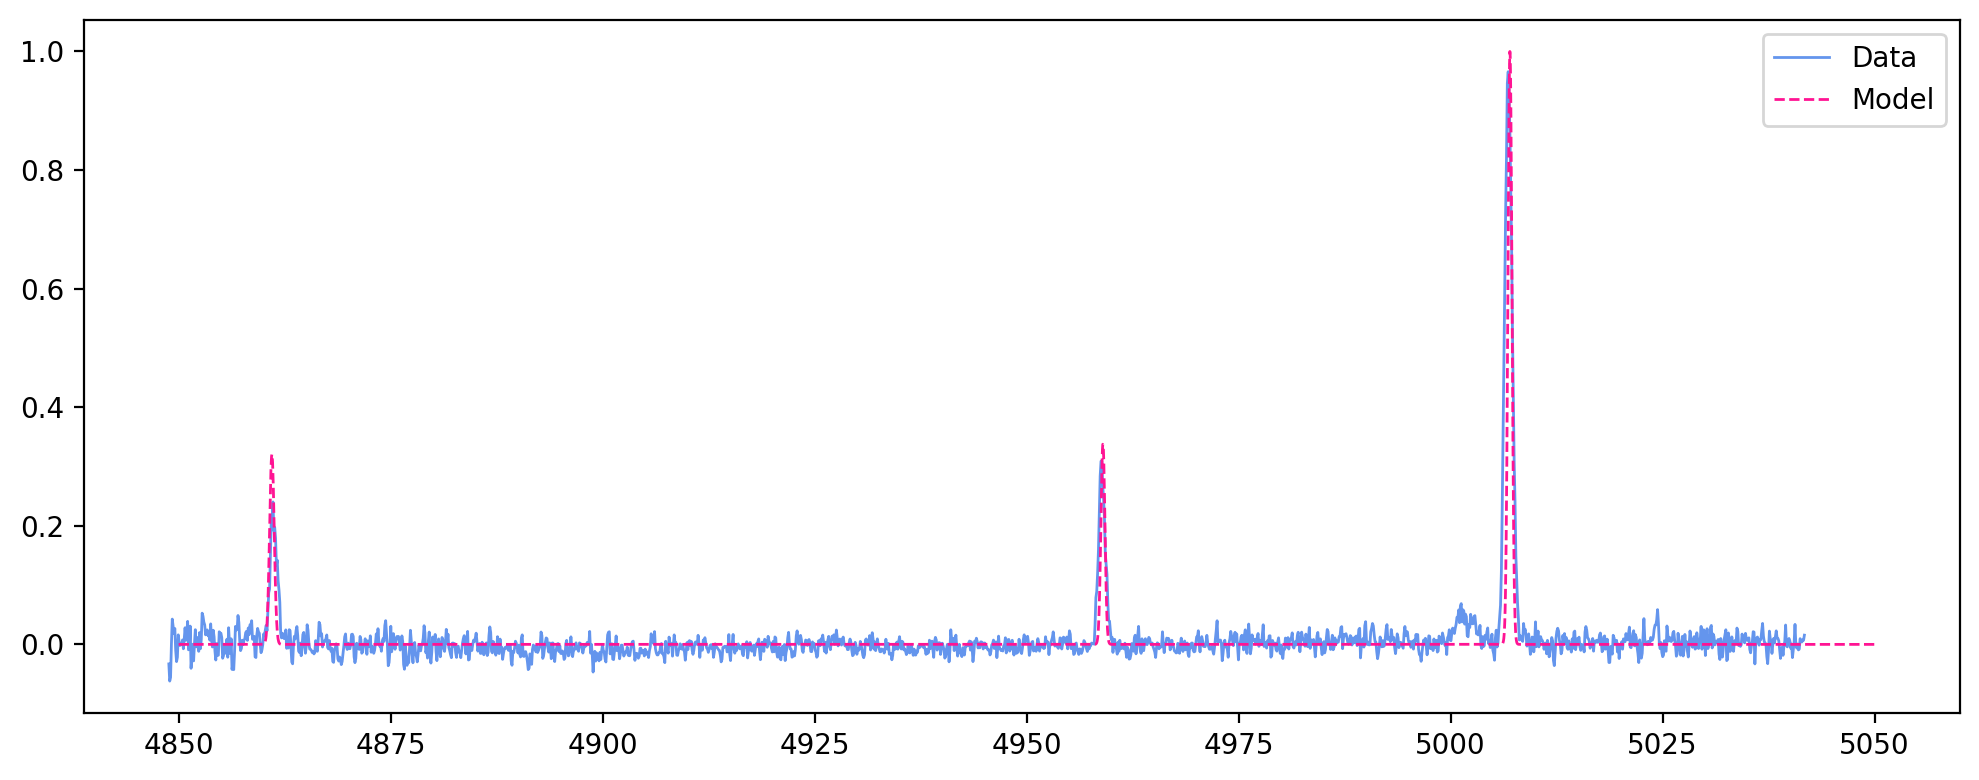

In [62]:
plt.figure(figsize=(10,4))
z = 0.00065

plt.plot(wave / (1 + z), (flux[0] - np.median(flux[0])) / np.max(flux[0]), label="Data", lw = 1, color = 'cornflowerblue')

plt.plot(wl, spec/np.max(spec), label='Model', color = 'deeppink', ls = '--', lw = 1)
# plt.plot(wl, spec, label='Model', color = 'deeppink', ls = '--', lw = 1)

# for comp in comps:
#     plt.plot(wave, comp, color="gold", alpha=0.7)  # individual Gaussians
# plt.plot(wave, comps.sum(axis=0), "r--", label="Multi Gaussian Model")
plt.legend()
# plt.xlabel('Wavelength')
# plt.ylabel('Flux')
plt.tight_layout()
